In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



In [ ]:
#load the two datasets
dfcab = pd.read_csv('cab_rides.csv', delimiter=',')
dfweather = pd.read_csv('weather.csv', delimiter=',')


# New Section

In [ ]:
#identify the missing values in the dataset
print(dfcab.isna().sum())
print(dfweather.isna().sum())

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64
temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64


In [ ]:
#get rid of missing values in price column and set missing values in 'rain' to be 0(Sunny days)
dfcab = dfcab.dropna(axis=0)
dfweather['rain'] = dfweather['rain'].fillna(0)

In [ ]:
#preprocess the timeStamp data
dfcab["time_stamp"] = dfcab["time_stamp"] / 1000
dfcab["time_stamp"] = dfcab["time_stamp"].apply(np.floor)
dfcab["time_stamp"] = dfcab["time_stamp"].astype(int)

In [ ]:
#merge the two datasets based on "source" and "timestamp"
dfweather = dfweather.rename(columns={"location":"source"})
merged_data = pd.merge(dfweather, dfcab, on=["source","time_stamp"])


In [ ]:
#convert time stamp data to date, time, weekday, hour, time_of_day
merged_data["date"] = merged_data["time_stamp"].apply(lambda x : datetime.fromtimestamp(x).date())
merged_data["time"] = merged_data["time_stamp"].apply(lambda x: datetime.fromtimestamp(x).time())
merged_data['weekday'] = merged_data['date'].apply(lambda x: x.weekday())
merged_data["weekday"] = merged_data["weekday"].map({0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7'})
merged_data['hour'] = merged_data['time'].apply(lambda time: time.hour)

merged_data['time_of_day'] = 0
merged_data.loc[(merged_data.hour >= 6) & (merged_data.hour < 12) , 'time_of_day'] = 'Morning'
merged_data.loc[(merged_data.hour >= 12) & (merged_data.hour < 15) , 'time_of_day'] = 'Afternoon'
merged_data.loc[(merged_data.hour >= 15) & (merged_data.hour < 18) , 'time_of_day'] = 'Evening'
merged_data.loc[(merged_data.hour >= 18) | (merged_data.hour < 6) , 'time_of_day'] = 'Night'


In [ ]:
merged_data

,temp,source,clouds,pressure,rain,time_stamp,humidity,wind,distance,cab_type,...,price,surge_multiplier,id,product_id,name,date,time,weekday,hour,time_of_day
0,39.23,Back Bay,0.83,996.09,0.0,1543449727,0.66,10.67,1.33,Lyft,...,13.5,1.0,e19a9b92-6717-4352-ab81-12732b1649bc,lyft_premier,Lux,2018-11-29,00:02:07,4,0,Night
1,39.23,Back Bay,0.83,996.09,0.0,1543449727,0.66,10.67,3.17,Uber,...,33.0,1.0,47d16c7f-252f-4d1b-9d5b-ada06e6303a4,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-29,00:02:07,4,0,Night
2,39.23,Back Bay,0.83,996.09,0.0,1543449727,0.66,10.67,3.17,Uber,...,10.0,1.0,6012faad-8797-4ff4-b392-8a587619bad8,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-29,00:02:07,4,0,Night
3,39.23,Back Bay,0.83,996.09,0.0,1543449727,0.66,10.67,3.17,Uber,...,10.0,1.0,697e16e1-1061-4feb-90ce-3127c03a3a8d,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-29,00:02:07,4,0,Night
4,39.23,Back Bay,0.83,996.09,0.0,1543449727,0.66,10.67,3.17,Uber,...,22.0,1.0,80491f32-e39d-4a06-94aa-90e17c53d3a4,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-29,00:02:07,4,0,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,38.78,Theatre District,0.04,992.11,0.0,1543365922,0.73,7.50,0.58,Uber,...,7.0,1.0,a943fd88-cbbc-4382-83e8-18706e5f1644,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-28,00:45:22,3,0,Night
3544,38.78,Theatre District,0.04,992.11,0.0,1543365922,0.73,7.50,0.58,Uber,...,7.0,1.0,bf407410-d978-4a8a-8f18-363b17b7d865,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-28,00:45:22,3,0,Night
3545,38.82,West End,0.04,992.10,0.0,1543365922,0.73,7.51,3.15,Uber,...,29.5,1.0,b2545dfd-27ce-4420-bf68-5fc8495250a5,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-28,00:45:22,3,0,Night
3546,38.82,West End,0.04,992.10,0.0,1543365922,0.73,7.51,3.15,Uber,...,23.0,1.0,fcd3b181-15e9-4ec9-8475-38d70f52f873,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-28,00:45:22,3,0,Night


In [ ]:
#drop useless columns
drop_cols = ['id','product_id','time_stamp']
merged_data = merged_data.drop(drop_cols, axis=1)

In [ ]:
merged_data

,temp,source,clouds,pressure,rain,humidity,wind,distance,cab_type,destination,price,surge_multiplier,name,date,time,weekday,hour,time_of_day
0,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,1.33,Lyft,South Station,13.5,1.0,Lux,2018-11-29,00:02:07,4,0,Night
1,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,33.0,1.0,Black SUV,2018-11-29,00:02:07,4,0,Night
2,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,10.0,1.0,WAV,2018-11-29,00:02:07,4,0,Night
3,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,10.0,1.0,UberX,2018-11-29,00:02:07,4,0,Night
4,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,22.0,1.0,Black,2018-11-29,00:02:07,4,0,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,38.78,Theatre District,0.04,992.11,0.0,0.73,7.50,0.58,Uber,South Station,7.0,1.0,WAV,2018-11-28,00:45:22,3,0,Night
3544,38.78,Theatre District,0.04,992.11,0.0,0.73,7.50,0.58,Uber,South Station,7.0,1.0,UberX,2018-11-28,00:45:22,3,0,Night
3545,38.82,West End,0.04,992.10,0.0,0.73,7.51,3.15,Uber,Northeastern University,29.5,1.0,Black SUV,2018-11-28,00:45:22,3,0,Night
3546,38.82,West End,0.04,992.10,0.0,0.73,7.51,3.15,Uber,Northeastern University,23.0,1.0,Black,2018-11-28,00:45:22,3,0,Night


In [ ]:
# hour to sin/cos transformation
hours_in_day = 24

merged_data['sin_hour'] = np.sin(2*np.pi*merged_data.hour/hours_in_day)
merged_data['cos_hour'] = np.cos(2*np.pi*merged_data.hour/hours_in_day)
merged_data

,temp,source,clouds,pressure,rain,humidity,wind,distance,cab_type,destination,price,surge_multiplier,name,date,time,weekday,hour,time_of_day,sin_hour,cos_hour
0,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,1.33,Lyft,South Station,13.5,1.0,Lux,2018-11-29,00:02:07,4,0,Night,0.000000,1.000000
1,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,33.0,1.0,Black SUV,2018-11-29,00:02:07,4,0,Night,0.000000,1.000000
2,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,10.0,1.0,WAV,2018-11-29,00:02:07,4,0,Night,0.000000,1.000000
3,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,10.0,1.0,UberX,2018-11-29,00:02:07,4,0,Night,0.000000,1.000000
4,39.23,Back Bay,0.83,996.09,0.0,0.66,10.67,3.17,Uber,North End,22.0,1.0,Black,2018-11-29,00:02:07,4,0,Night,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,38.78,Theatre District,0.04,992.11,0.0,0.73,7.50,0.58,Uber,South Station,7.0,1.0,WAV,2018-11-28,00:45:22,3,0,Night,0.000000,1.000000
3544,38.78,Theatre District,0.04,992.11,0.0,0.73,7.50,0.58,Uber,South Station,7.0,1.0,UberX,2018-11-28,00:45:22,3,0,Night,0.000000,1.000000
3545,38.82,West End,0.04,992.10,0.0,0.73,7.51,3.15,Uber,Northeastern University,29.5,1.0,Black SUV,2018-11-28,00:45:22,3,0,Night,0.000000,1.000000
3546,38.82,West End,0.04,992.10,0.0,0.73,7.51,3.15,Uber,Northeastern University,23.0,1.0,Black,2018-11-28,00:45:22,3,0,Night,0.000000,1.000000


In [ ]:
#create Uber and Lyft's separate datasets
dfUber = merged_data[merged_data['cab_type'] == "Uber"]
dfLyft = merged_data[merged_data['cab_type'] == "Lyft"]

In [ ]:
#Feature Selection and Model Training for Uber
dfUber_price = dfUber['price']
#drop columns that is unnecessary for model training
dfUber = dfUber.drop(['date','time','source','destination','time_of_day','cab_type','hour','surge_multiplier'],1)
columnUber = dfUber.columns

<ipython-input-13-dba0948d8ed6>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfUber = dfUber.drop(['date','time','source','destination','time_of_day','cab_type','hour','surge_multiplier'],1)


In [ ]:
print(dfUber)
print(columnUber)

       temp  clouds  pressure  rain  humidity   wind  distance  price  \
1     39.23    0.83    996.09   0.0      0.66  10.67      3.17   33.0   
2     39.23    0.83    996.09   0.0      0.66  10.67      3.17   10.0   
3     39.23    0.83    996.09   0.0      0.66  10.67      3.17   10.0   
4     39.23    0.83    996.09   0.0      0.66  10.67      3.17   22.0   
8     39.18    0.83    996.08   0.0      0.67  10.69      1.35    8.5   
...     ...     ...       ...   ...       ...    ...       ...    ...   
3543  38.78    0.04    992.11   0.0      0.73   7.50      0.58    7.0   
3544  38.78    0.04    992.11   0.0      0.73   7.50      0.58    7.0   
3545  38.82    0.04    992.10   0.0      0.73   7.51      3.15   29.5   
3546  38.82    0.04    992.10   0.0      0.73   7.51      3.15   23.0   
3547  40.89    0.94    993.48   0.0      0.64   8.45      2.81   31.0   

           name weekday  sin_hour  cos_hour  
1     Black SUV       4  0.000000  1.000000  
2           WAV       4  0.0000

In [ ]:
# standardize numerical variables
dfUber[['temp','clouds','pressure','rain','humidity','wind','distance','weekday']] = StandardScaler().fit_transform(dfUber[['temp','clouds','pressure','rain','humidity','wind','distance','weekday']])

In [ ]:
#convert categorical Uber car type to dummy variables
df1 = pd.get_dummies(dfUber['name'])
dfUber = pd.concat([dfUber, df1], axis=1).reindex(dfUber.index)
dfUber.drop('name', axis=1, inplace=True)

In [ ]:
dfUber

,temp,clouds,pressure,rain,humidity,wind,distance,price,weekday,sin_hour,cos_hour,Black,Black SUV,UberPool,UberX,UberXL,WAV
1,-0.004342,0.443598,-0.313110,-0.215583,-0.989591,0.865979,0.840693,33.0,1.133740,0.000000,1.000000,0,1,0,0,0,0
2,-0.004342,0.443598,-0.313110,-0.215583,-0.989591,0.865979,0.840693,10.0,1.133740,0.000000,1.000000,0,0,0,0,0,1
3,-0.004342,0.443598,-0.313110,-0.215583,-0.989591,0.865979,0.840693,10.0,1.133740,0.000000,1.000000,0,0,0,1,0,0
4,-0.004342,0.443598,-0.313110,-0.215583,-0.989591,0.865979,0.840693,22.0,1.133740,0.000000,1.000000,1,0,0,0,0,0
8,-0.018713,0.443598,-0.314285,-0.215583,-0.893858,0.872517,-0.728973,8.5,1.133740,0.000000,1.000000,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,-0.133685,-2.222412,-0.780687,-0.215583,-0.319461,-0.170268,-1.393062,7.0,0.208404,0.000000,1.000000,0,0,0,0,0,1
3544,-0.133685,-2.222412,-0.780687,-0.215583,-0.319461,-0.170268,-1.393062,7.0,0.208404,0.000000,1.000000,0,0,0,1,0,0
3545,-0.122188,-2.222412,-0.781862,-0.215583,-0.319461,-0.166999,0.823444,29.5,0.208404,0.000000,1.000000,0,1,0,0,0,0
3546,-0.122188,-2.222412,-0.781862,-0.215583,-0.319461,-0.166999,0.823444,23.0,0.208404,0.000000,1.000000,1,0,0,0,0,0


In [ ]:
#Feature Selection

               temp    clouds  pressure      rain  humidity      wind  \
temp       1.000000  0.714976  0.546374  0.302850  0.116488  0.155134   
clouds     0.714976  1.000000  0.509322  0.214940  0.126374  0.021202   
pressure   0.546374  0.509322  1.000000  0.147793  0.653879 -0.499440   
rain       0.302850  0.214940  0.147793  1.000000  0.290676  0.292450   
humidity   0.116488  0.126374  0.653879  0.290676  1.000000 -0.597235   
wind       0.155134  0.021202 -0.499440  0.292450 -0.597235  1.000000   
distance   0.021997  0.039053  0.015984 -0.037571  0.027384 -0.058283   
price      0.027242  0.048888  0.008739 -0.025697 -0.006237 -0.035490   
weekday   -0.477197 -0.452284 -0.626232 -0.156181 -0.676640  0.499847   
sin_hour  -0.476137 -0.313663  0.206425  0.052953  0.514413 -0.412539   
cos_hour   0.415218  0.310158  0.110837  0.240701 -0.198664  0.535080   
Black     -0.000370 -0.002704 -0.028352 -0.008708 -0.041135  0.016360   
Black SUV  0.033967  0.046378  0.022814  0.002128  

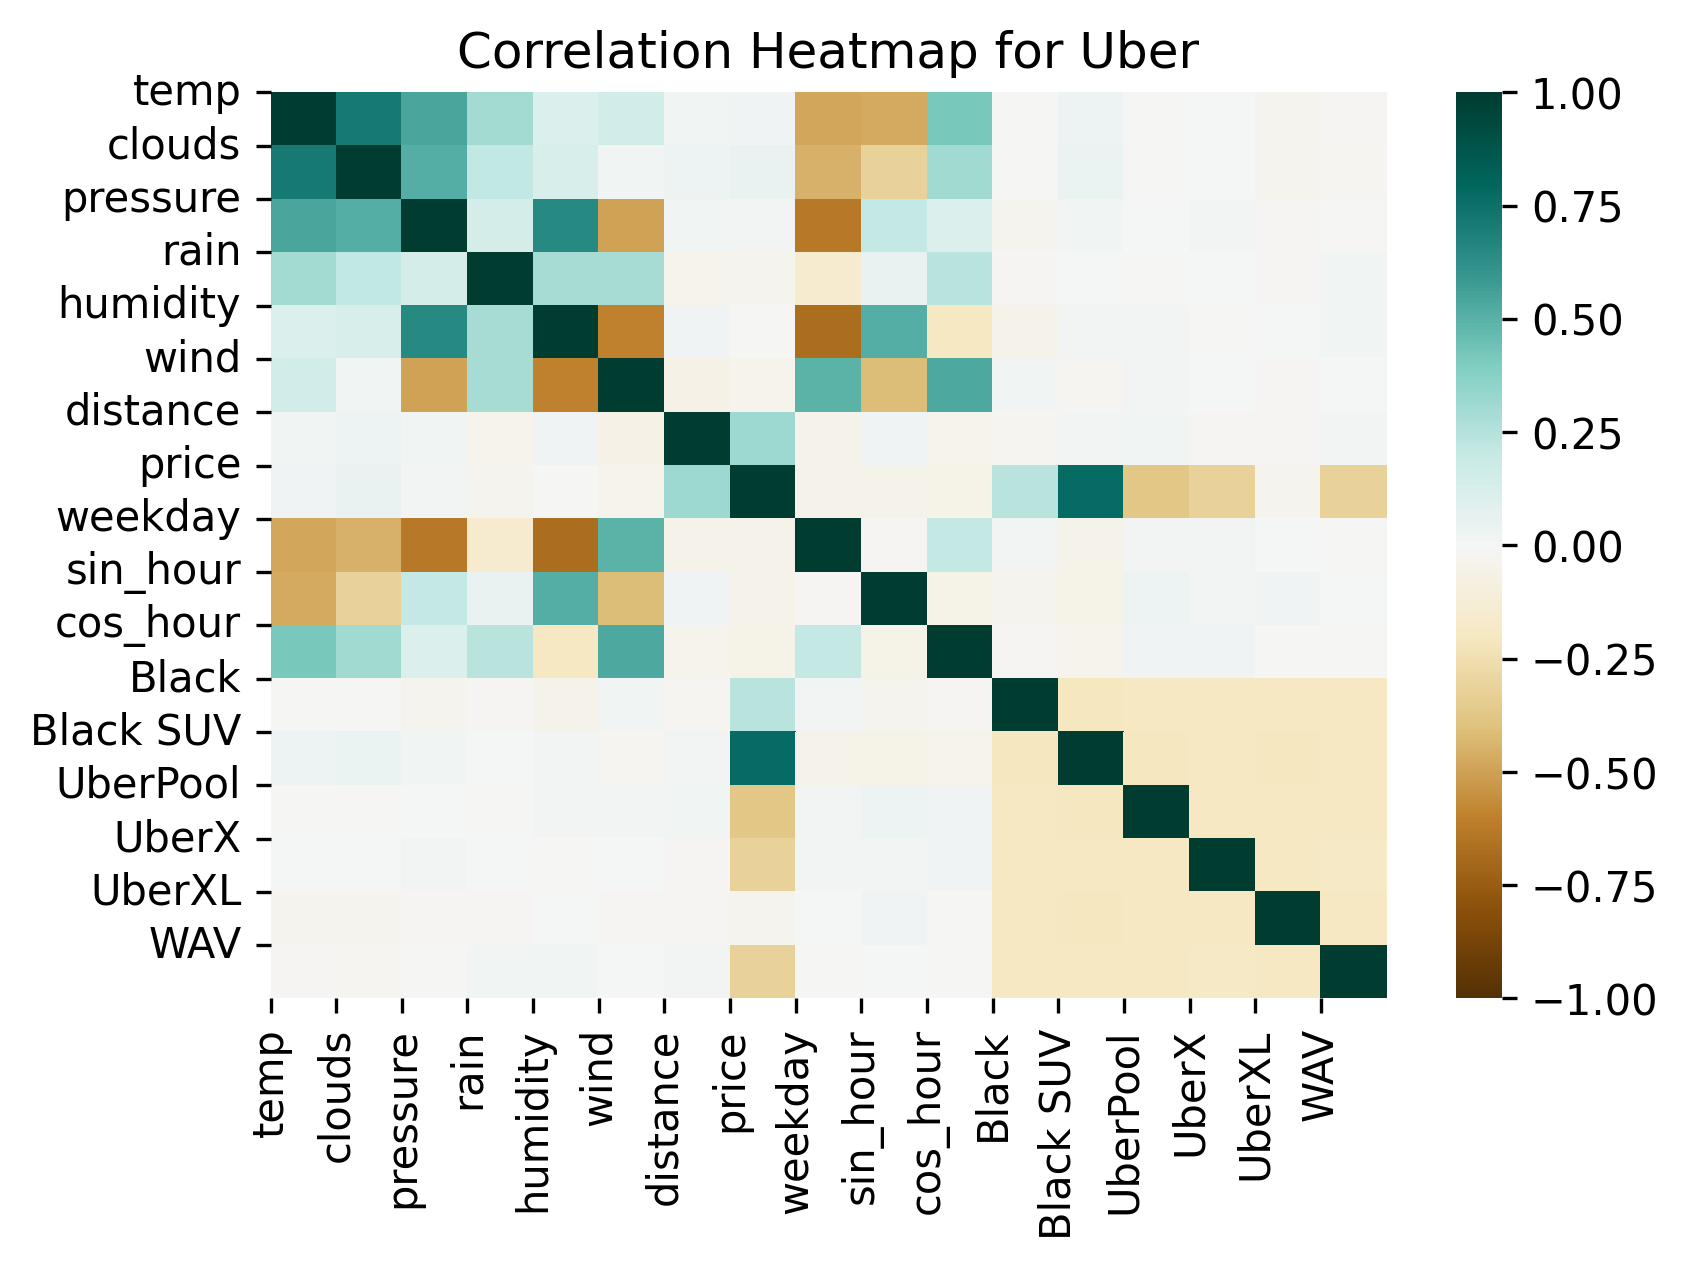

In [ ]:
# create a correlation matrix for Uber and draw heatmap
matrixUber = dfUber.corr(method ='pearson')
print(matrixUber)

ax = sns.heatmap(matrixUber,vmin=-1, vmax=1, cmap='BrBG')
ax.set_xticks(np.arange(len(matrixUber)))
ax.set_yticks(np.arange(len(matrixUber)))
ax.set_xticklabels(matrixUber.index)
ax.set_yticklabels(matrixUber.index)
plt.rcParams['figure.dpi'] = 500
plt.title('Correlation Heatmap for Uber')
plt.show()

In [ ]:
#form training and testing set for Uber
dfUber = dfUber.drop(['pressure','humidity','price'],1)


<ipython-input-20-fca5b2fe1660>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfUber = dfUber.drop(['pressure','humidity','price'],1)


In [ ]:
dfUber

,temp,clouds,rain,wind,distance,weekday,sin_hour,cos_hour,Black,Black SUV,UberPool,UberX,UberXL,WAV
1,-0.004342,0.443598,-0.215583,0.865979,0.840693,1.133740,0.000000,1.000000,0,1,0,0,0,0
2,-0.004342,0.443598,-0.215583,0.865979,0.840693,1.133740,0.000000,1.000000,0,0,0,0,0,1
3,-0.004342,0.443598,-0.215583,0.865979,0.840693,1.133740,0.000000,1.000000,0,0,0,1,0,0
4,-0.004342,0.443598,-0.215583,0.865979,0.840693,1.133740,0.000000,1.000000,1,0,0,0,0,0
8,-0.018713,0.443598,-0.215583,0.872517,-0.728973,1.133740,0.000000,1.000000,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,-0.133685,-2.222412,-0.215583,-0.170268,-1.393062,0.208404,0.000000,1.000000,0,0,0,0,0,1
3544,-0.133685,-2.222412,-0.215583,-0.170268,-1.393062,0.208404,0.000000,1.000000,0,0,0,1,0,0
3545,-0.122188,-2.222412,-0.215583,-0.166999,0.823444,0.208404,0.000000,1.000000,0,1,0,0,0,0
3546,-0.122188,-2.222412,-0.215583,-0.166999,0.823444,0.208404,0.000000,1.000000,1,0,0,0,0,0


In [ ]:
featureUber = dfUber.columns
dfUber_np = dfUber.to_numpy()
print(featureUber)
xTrainUber, xTestUber, yTrainUber, yTestUber = train_test_split(dfUber_np, dfUber_price, test_size=0.3)

Index(['temp', 'clouds', 'rain', 'wind', 'distance', 'weekday', 'sin_hour',
       'cos_hour', 'Black', 'Black SUV', 'UberPool', 'UberX', 'UberXL', 'WAV'],
      dtype='object')


Best learning rate for Gradient Boosting for Uber: 0.1


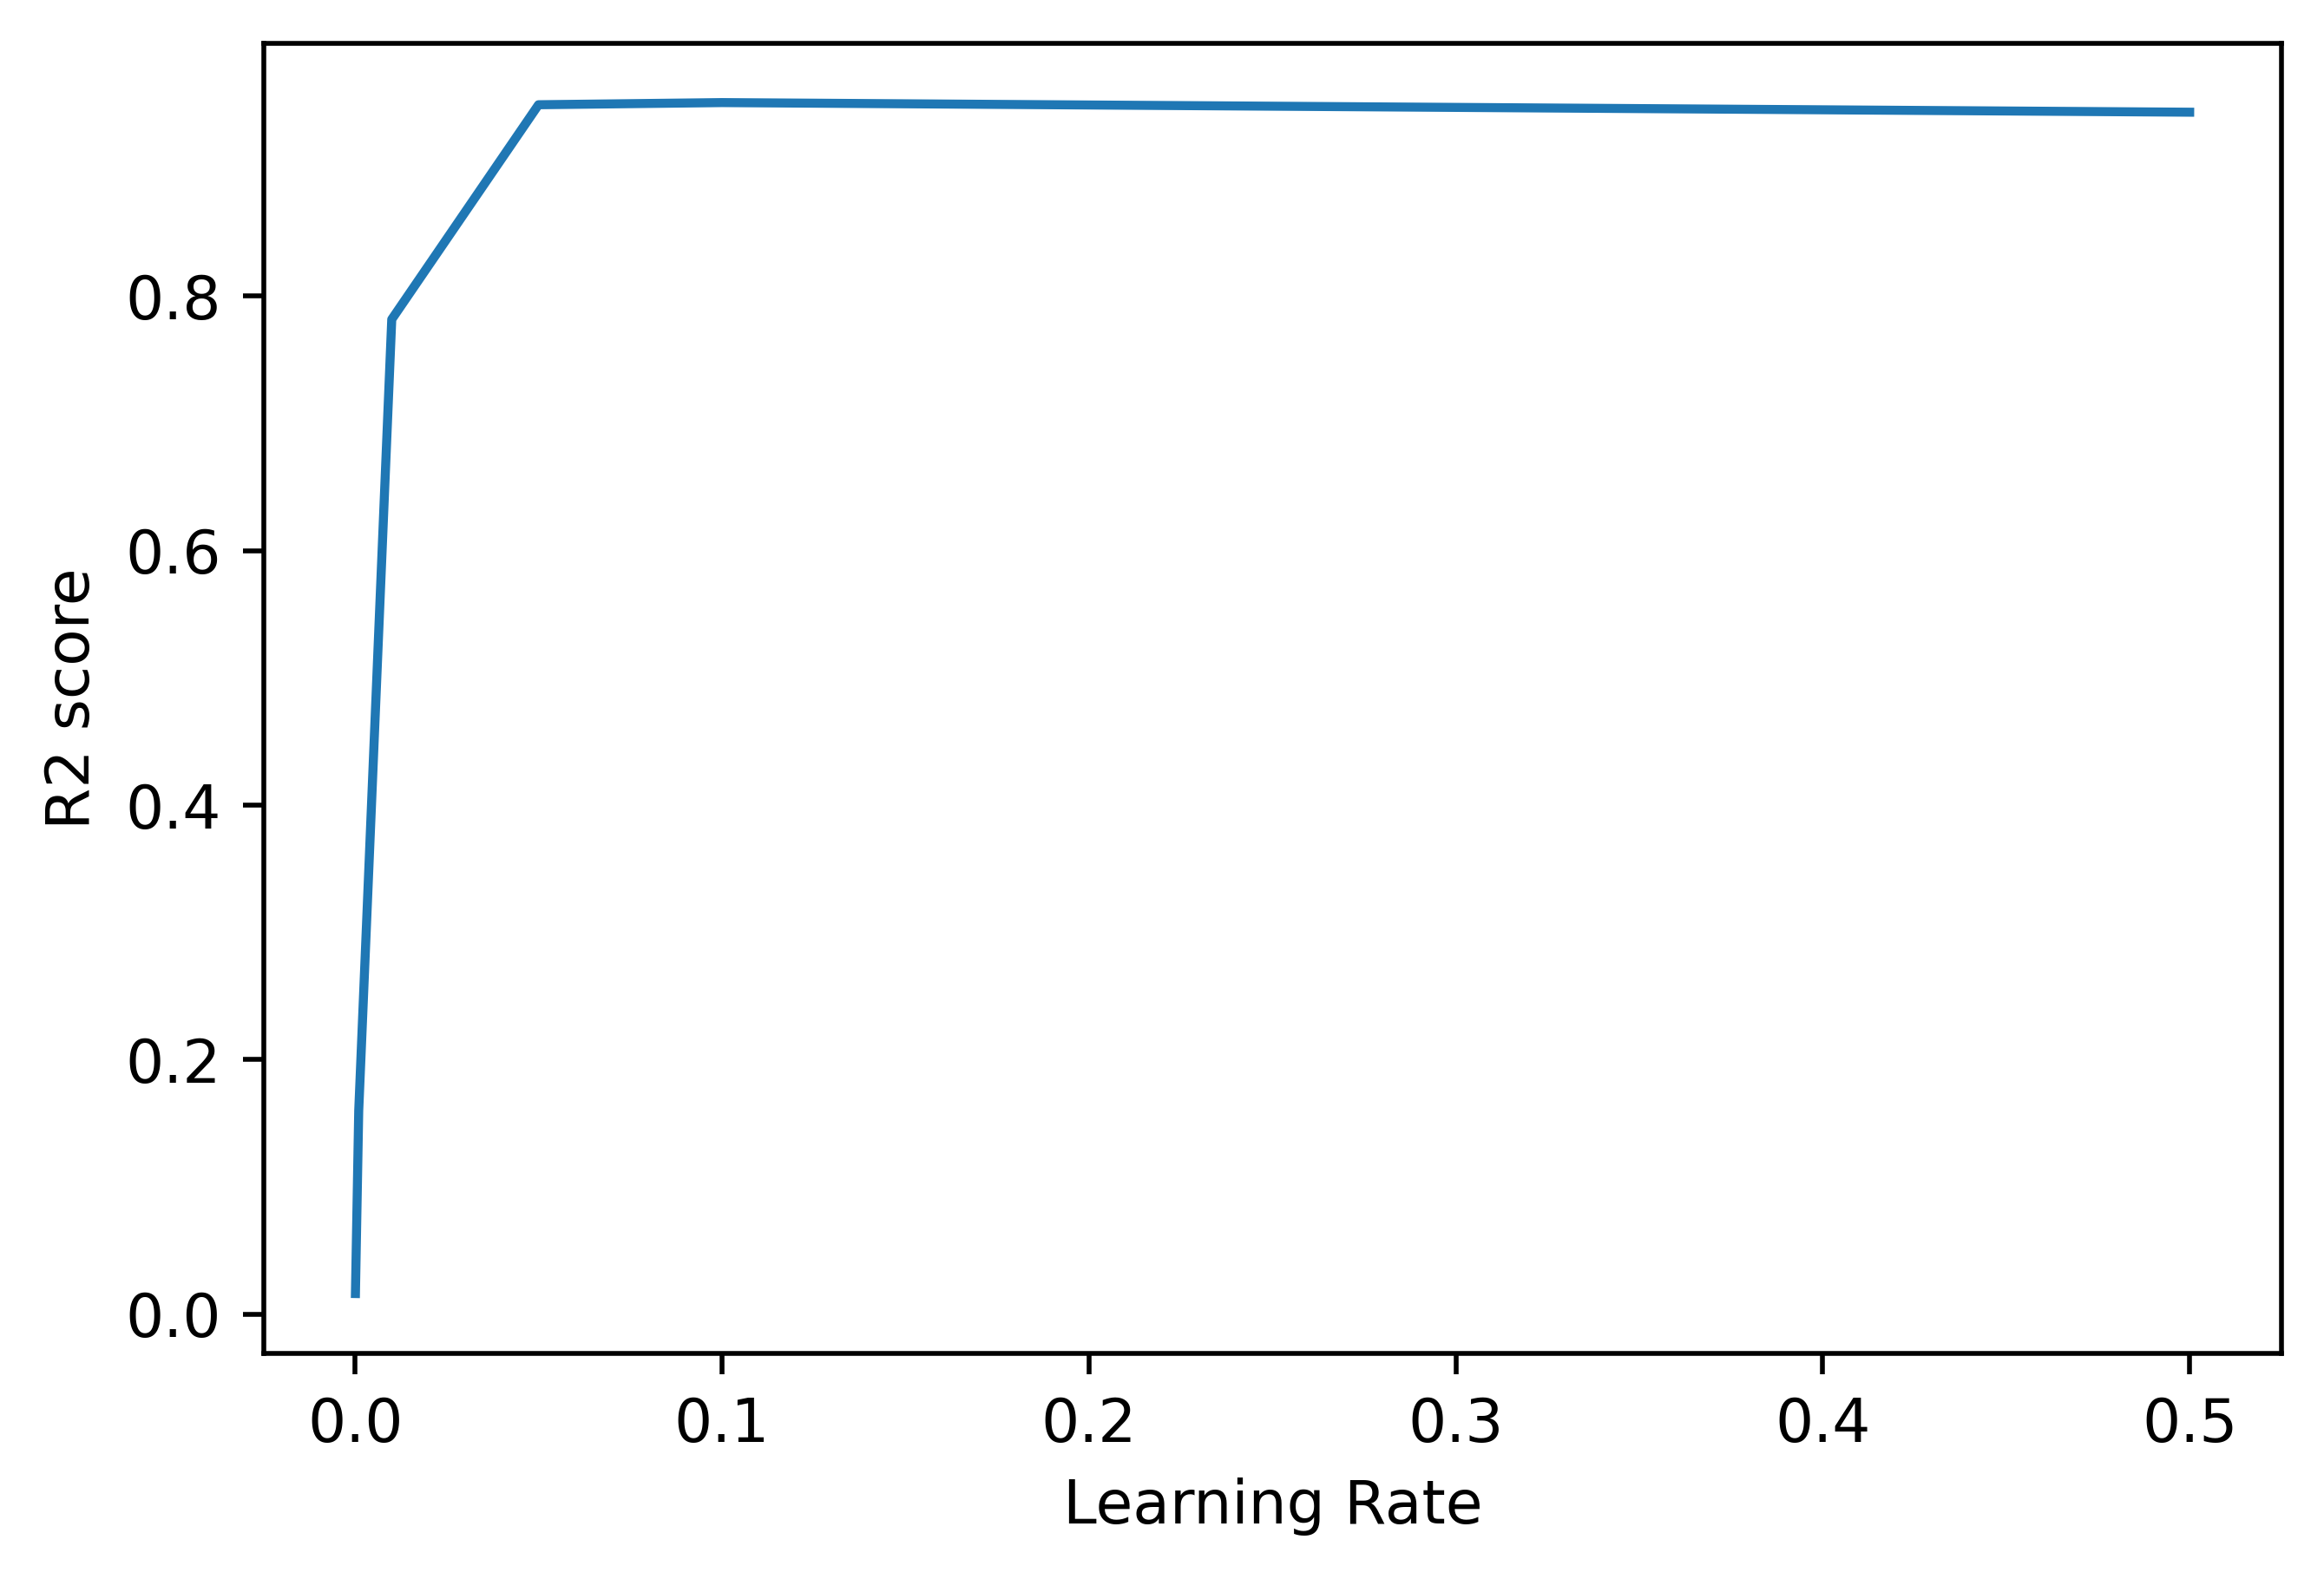

In [ ]:
#Gradient Boosting Model Training - Uber
#hyper parameter tuning to select the best lr
lrs = [0.0001,0.001,0.01,0.05,0.1,0.5]
# empty list that will hold cv scores
cv_scores = []
for k in lrs:
    GB = GradientBoostingRegressor(learning_rate=k)
    scores = cross_val_score(GB, xTrainUber, yTrainUber, cv=5, scoring='r2')
    cv_scores.append(scores.mean())
r2 = []
r2 = [x for x in cv_scores]
#optimal K
optimal_k_index = r2.index(max(r2))
optimal_k = lrs[optimal_k_index]
print("Best learning rate for Gradient Boosting for Uber:", optimal_k)
#plot graph
plt.plot(lrs, r2)
plt.xlabel('Learning Rate')
plt.ylabel('R2 score')
plt.show()

In [ ]:
# Gradient Boosting - Uber
# find coefficients and R2 score for test set
from sklearn.ensemble import GradientBoostingRegressor
GB = GradientBoostingRegressor(learning_rate=0.1)

yHatGBUber = GB.fit(xTrainUber, yTrainUber).predict(xTestUber)
GBmseUber = metrics.mean_squared_error(yTestUber, yHatGBUber)
GBr2Uber = metrics.r2_score(yTestUber, yHatGBUber)
print("Uber MSE:", GBmseUber, "; r-squared:", GBr2Uber)

Uber MSE: 3.3081653428592936 ; r-squared: 0.9461581043812806


Best depth for Decision Tree for Uber: 5


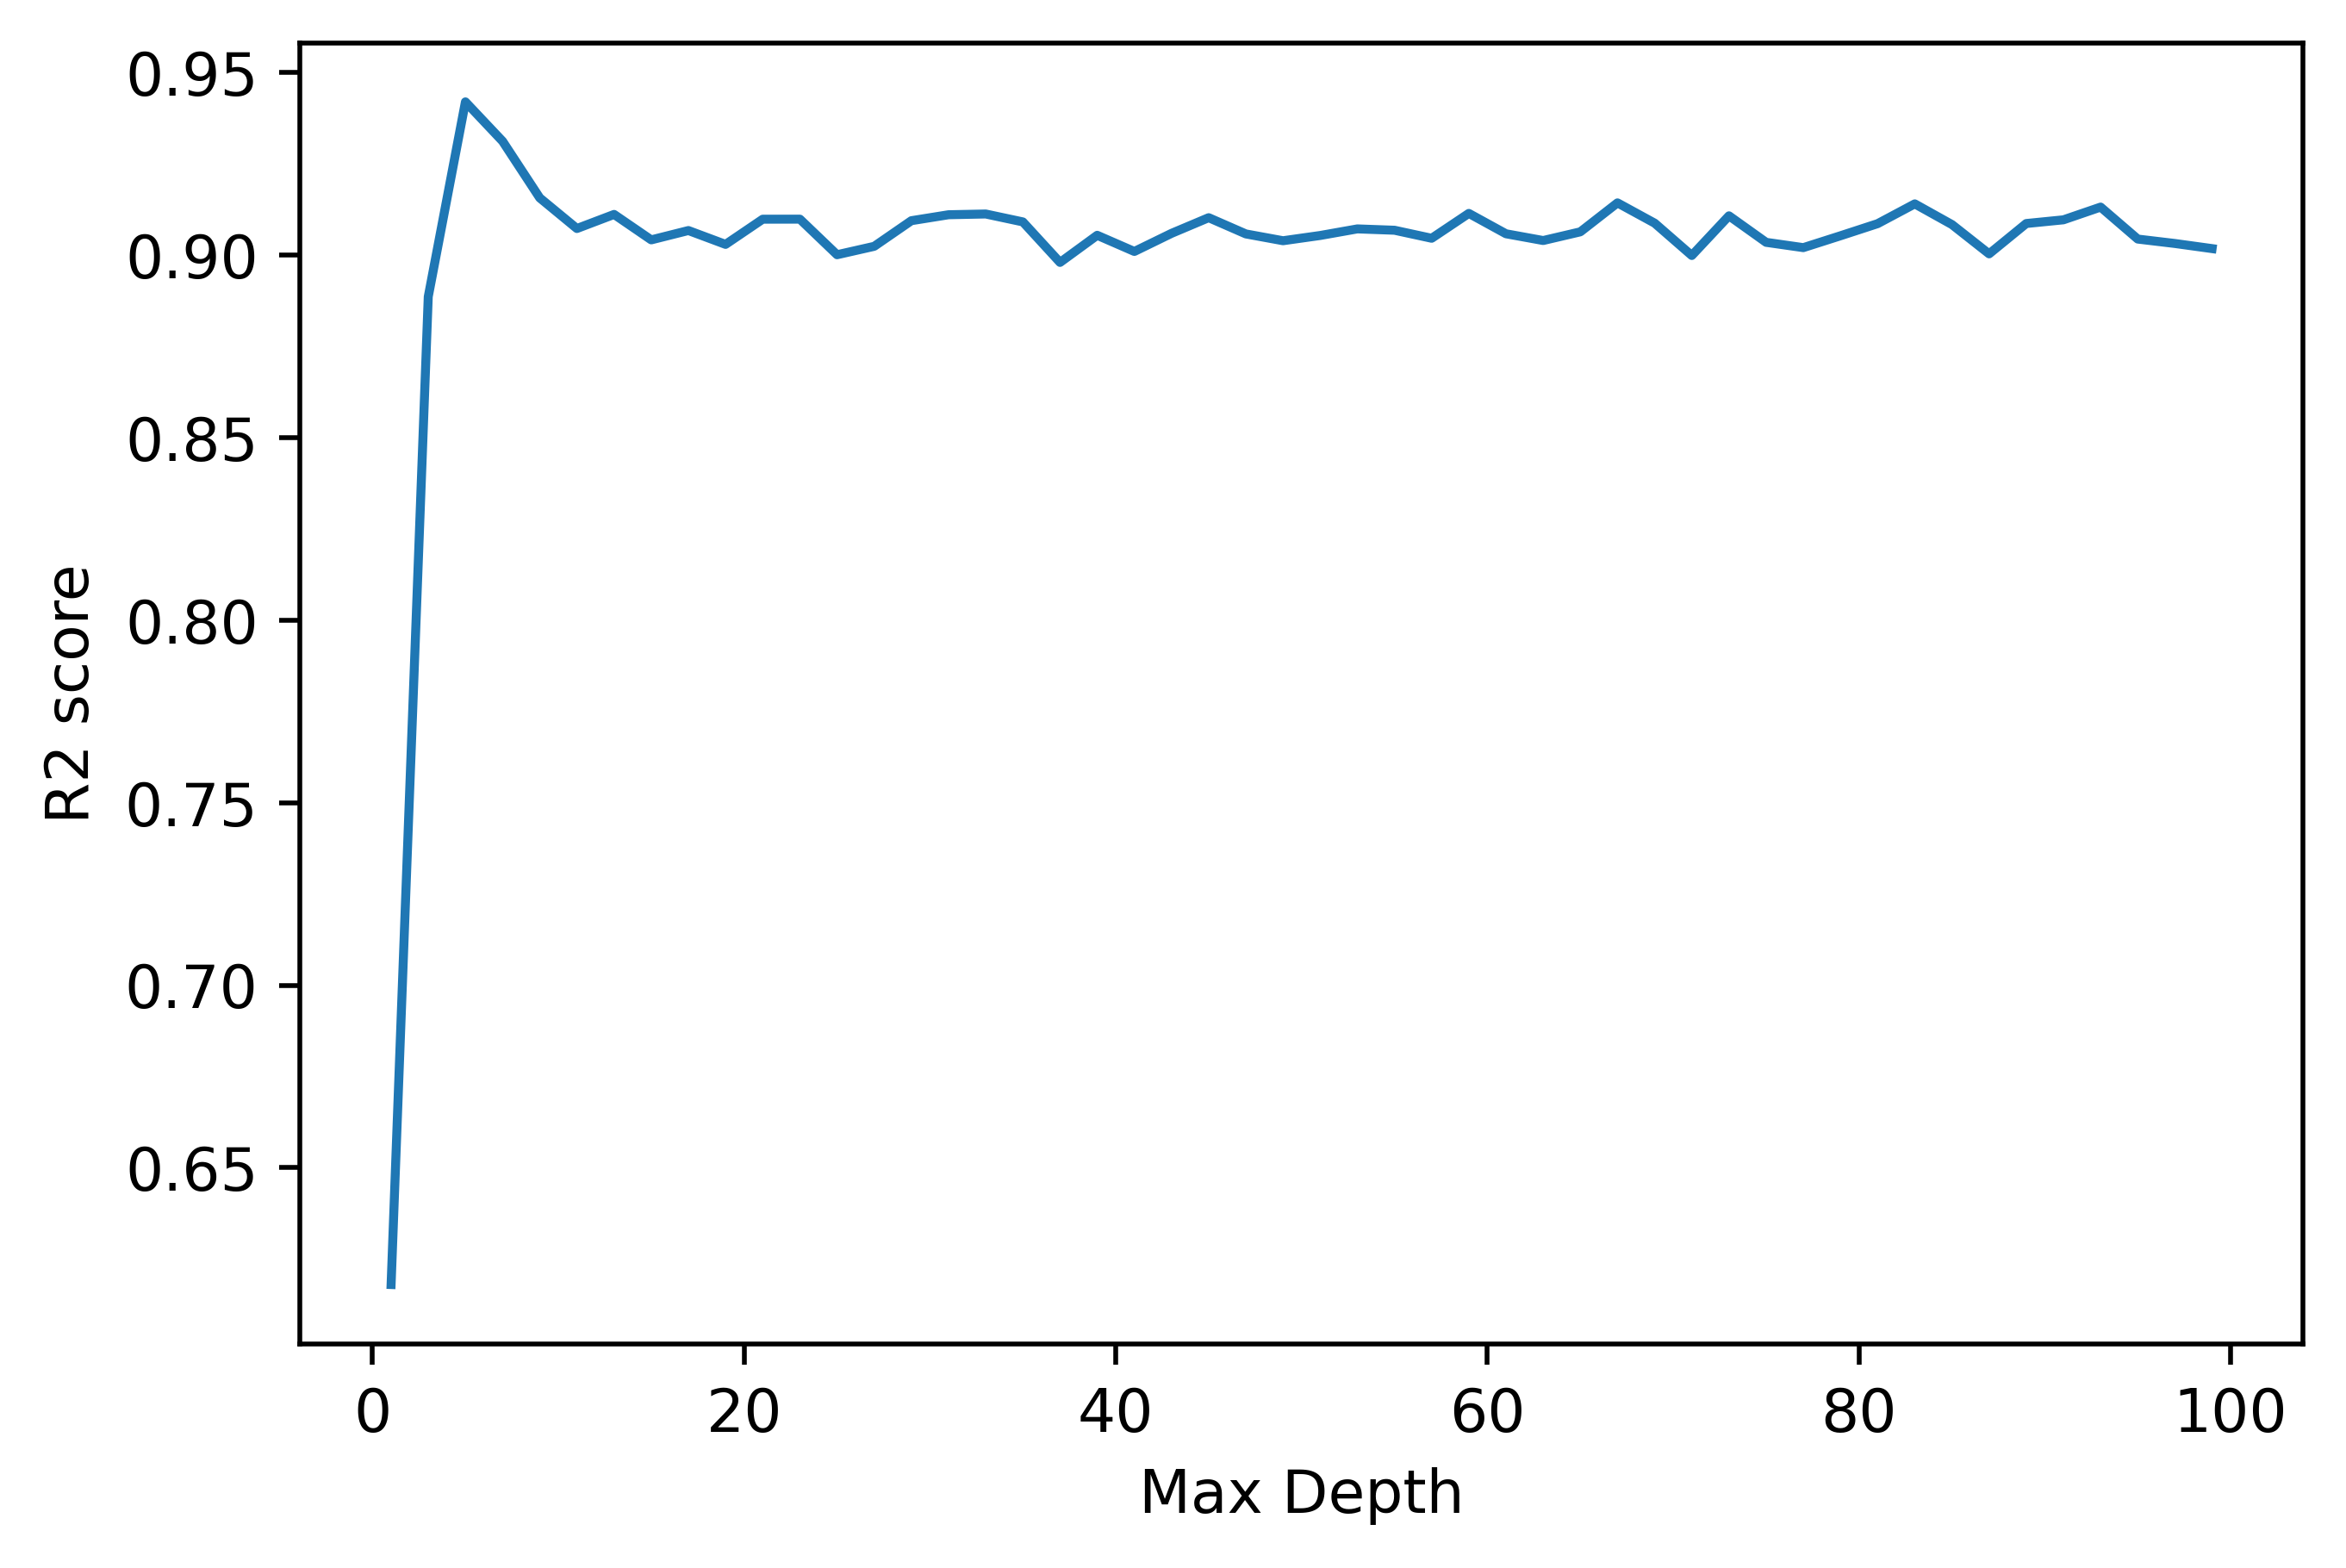

In [ ]:
# Decision Tree - Uber
# hyper parameter tuning.Selecting best max depth
depths = [x for x in range(1,100) if x % 2 != 0]
# empty list that will hold cv scores
cv_scores = []
for k in depths:
    DT = DecisionTreeRegressor(max_depth=k)
    scores = cross_val_score(DT, xTrainUber, yTrainUber, cv=5, scoring='r2')
    cv_scores.append(scores.mean())
r2 = [x for x in cv_scores]
#optimal K
optimal_k_index = r2.index(max(r2))
optimal_k = depths[optimal_k_index]
print("Best depth for Decision Tree for Uber:", optimal_k)
#plot graph
plt.plot(depths, r2)
plt.xlabel('Max Depth')
plt.ylabel('R2 score')
plt.show()

In [ ]:
DT = DecisionTreeRegressor(max_depth=5)
yHatDTUber = DT.fit(xTrainUber, yTrainUber).predict(xTestUber)

DTmseUber = metrics.mean_squared_error(yTestUber, yHatDTUber)
DTr2Uber = metrics.r2_score(yTestUber, yHatDTUber)
print("Uber MSE:", DTmseUber, "; r-squared:", DTr2Uber)



Uber MSE: 4.2710039236467106 ; r-squared: 0.9304874685479383


Best depth for Random Forest for Uber: 5


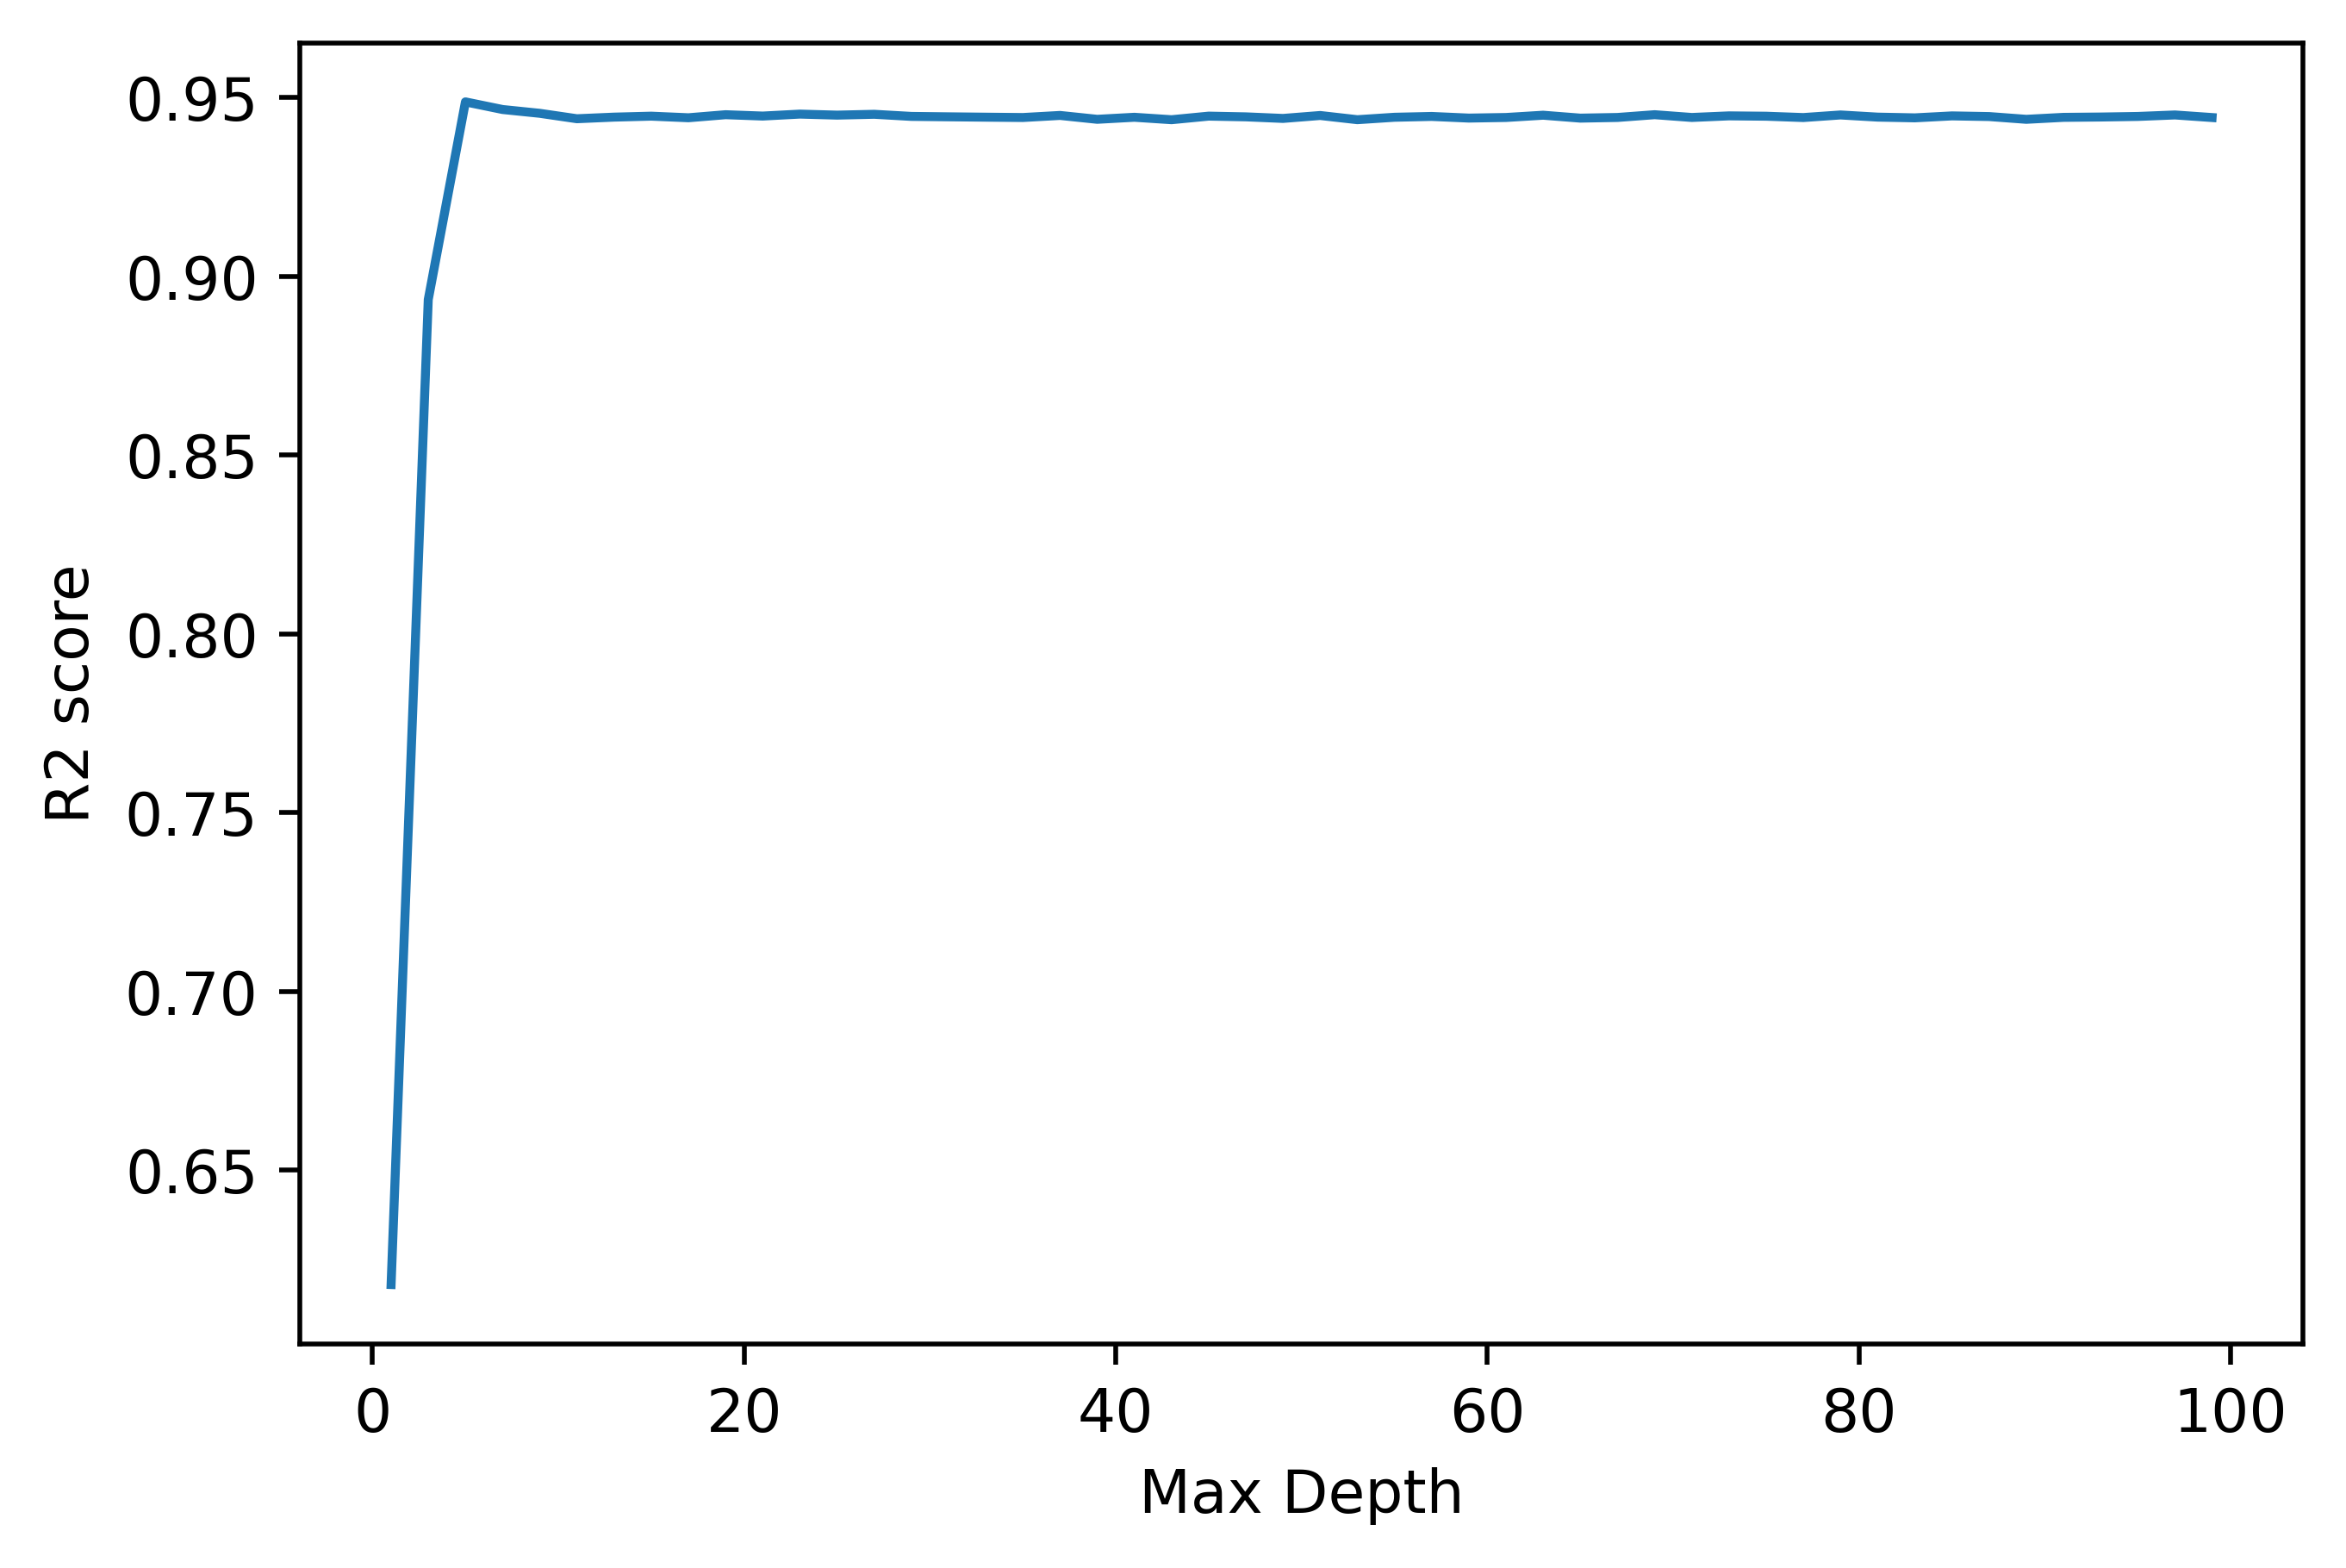

In [ ]:
# Models
# Random Forest - Uber
# hyper parameter tuning.Selecting best max depth
depths = [x for x in range(1,100) if x % 2 != 0]
# empty list that will hold cv scores
cv_scores = []
for k in depths:
    RF = RandomForestRegressor(max_depth=k)
    scores = cross_val_score(RF, xTrainUber, yTrainUber, cv=5, scoring='r2')
    cv_scores.append(scores.mean())
r2 = [x for x in cv_scores]
#optimal K
optimal_k_index = r2.index(max(r2))
optimal_k = depths[optimal_k_index]
print("Best depth for Random Forest for Uber:", optimal_k)
#plot graph
plt.plot(depths, r2)
plt.xlabel('Max Depth')
plt.ylabel('R2 score')
plt.show()

In [ ]:
RF = RandomForestRegressor(max_depth=7)
yHatRFUber = RF.fit(xTrainUber, yTrainUber).predict(xTestUber)

RFmseUber = metrics.mean_squared_error(yTestUber, yHatRFUber)
RFr2Uber = metrics.r2_score(yTestUber, yHatRFUber)
print("Uber MSE:", RFmseUber, "; r-squared:", RFr2Uber)


Uber MSE: 3.6764017613781053 ; r-squared: 0.9401648891837099


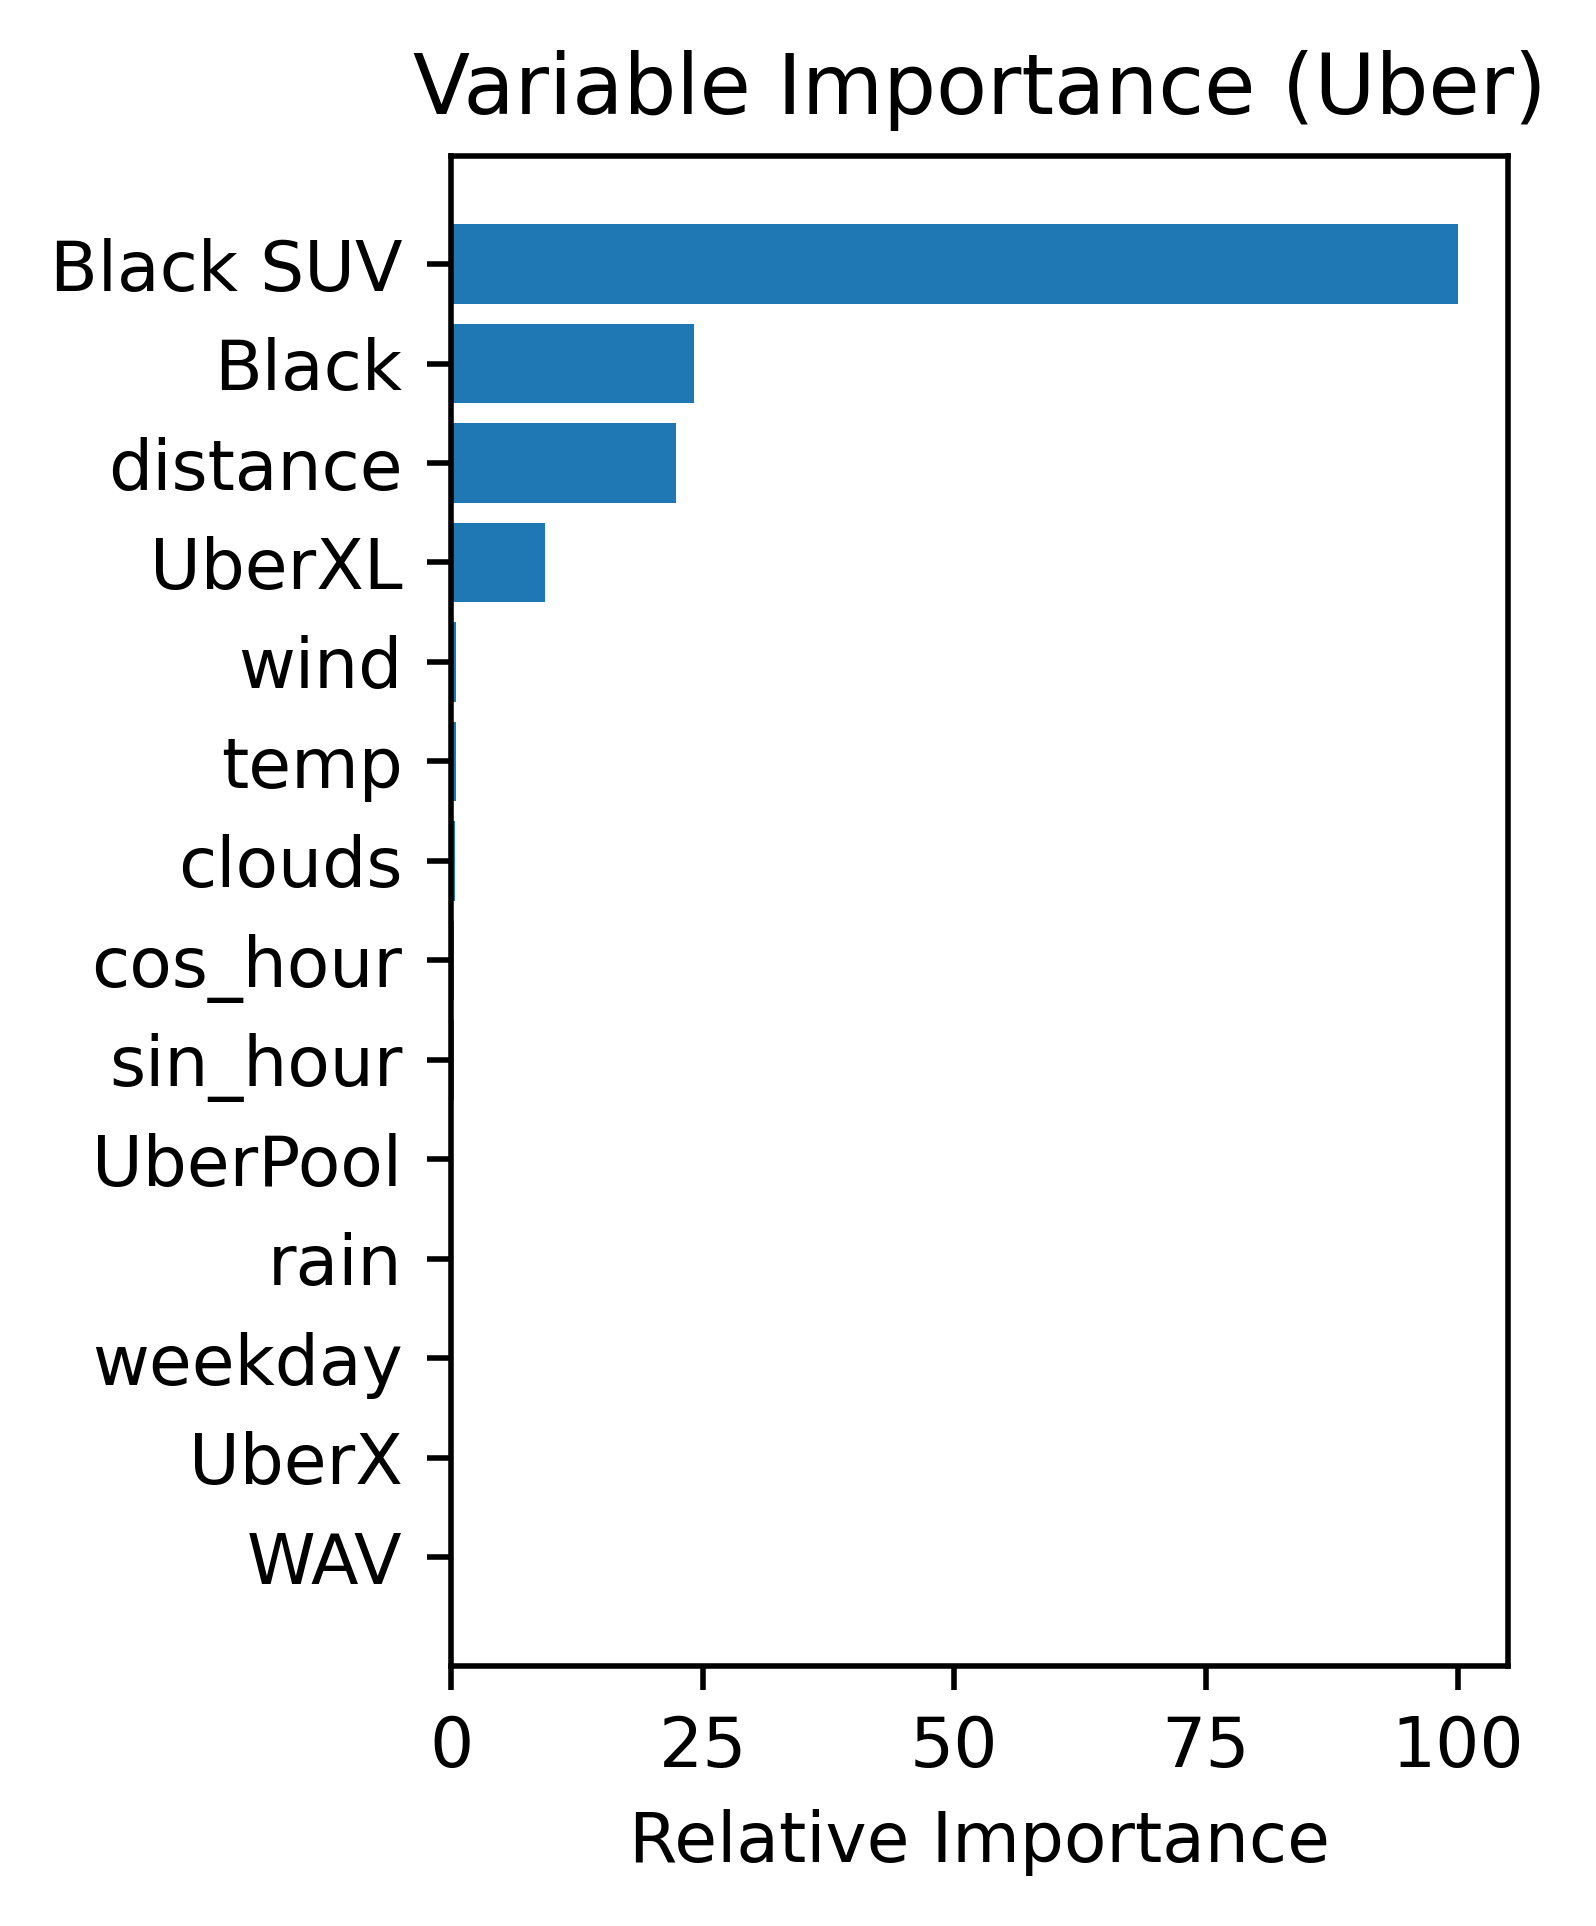

In [ ]:
# Plot feature importance
feature_importance = RF.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, dfUber.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Uber)')
plt.show()

In [ ]:
#Lyft Data Building and Model Training

In [ ]:
#Feature Selection and Model Training for Uber
dfLyft_price = dfLyft['price']
#drop columns that is unnecessary for model training
dfLyft = dfLyft.drop(['date','time','source','destination','time_of_day','cab_type','hour','surge_multiplier'],1)
columnLyft = dfLyft.columns

<ipython-input-30-2b86b127a142>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfLyft = dfLyft.drop(['date','time','source','destination','time_of_day','cab_type','hour','surge_multiplier'],1)


In [ ]:
print(dfLyft)
print(columnLyft)

In [ ]:
# standardize numerical variables
dfLyft[['temp','clouds','pressure','rain','humidity','wind','distance','weekday']] = StandardScaler().fit_transform(dfLyft[['temp','clouds','pressure','rain','humidity','wind','distance','weekday']])

In [ ]:
#convert categorical Uber car type to dummy variables
df1 = pd.get_dummies(dfLyft['name'])
dfLyft = pd.concat([dfLyft, df1], axis=1).reindex(dfLyft.index)
dfLyft.drop('name', axis=1, inplace=True)

In [ ]:
dfLyft

                  temp    clouds  pressure      rain  humidity      wind  \
temp          1.000000  0.717914  0.417982  0.259780  0.106063  0.124565   
clouds        0.717914  1.000000  0.513833  0.189464  0.172422 -0.084515   
pressure      0.417982  0.513833  1.000000  0.114155  0.664840 -0.555909   
rain          0.259780  0.189464  0.114155  1.000000  0.241253  0.223560   
humidity      0.106063  0.172422  0.664840  0.241253  1.000000 -0.670275   
wind          0.124565 -0.084515 -0.555909  0.223560 -0.670275  1.000000   
distance     -0.024812  0.010613 -0.003667  0.016674 -0.033009  0.059220   
price         0.021605  0.032599  0.014072  0.002737 -0.001168  0.014681   
weekday      -0.513463 -0.477581 -0.554844 -0.129339 -0.686245  0.548642   
sin_hour     -0.489398 -0.301858  0.261980  0.030931  0.511643 -0.437841   
cos_hour      0.332340  0.269448  0.164858  0.214285 -0.128022  0.440383   
Lux          -0.002940  0.004733 -0.019776 -0.000111 -0.052374  0.027039   
Lux Black   

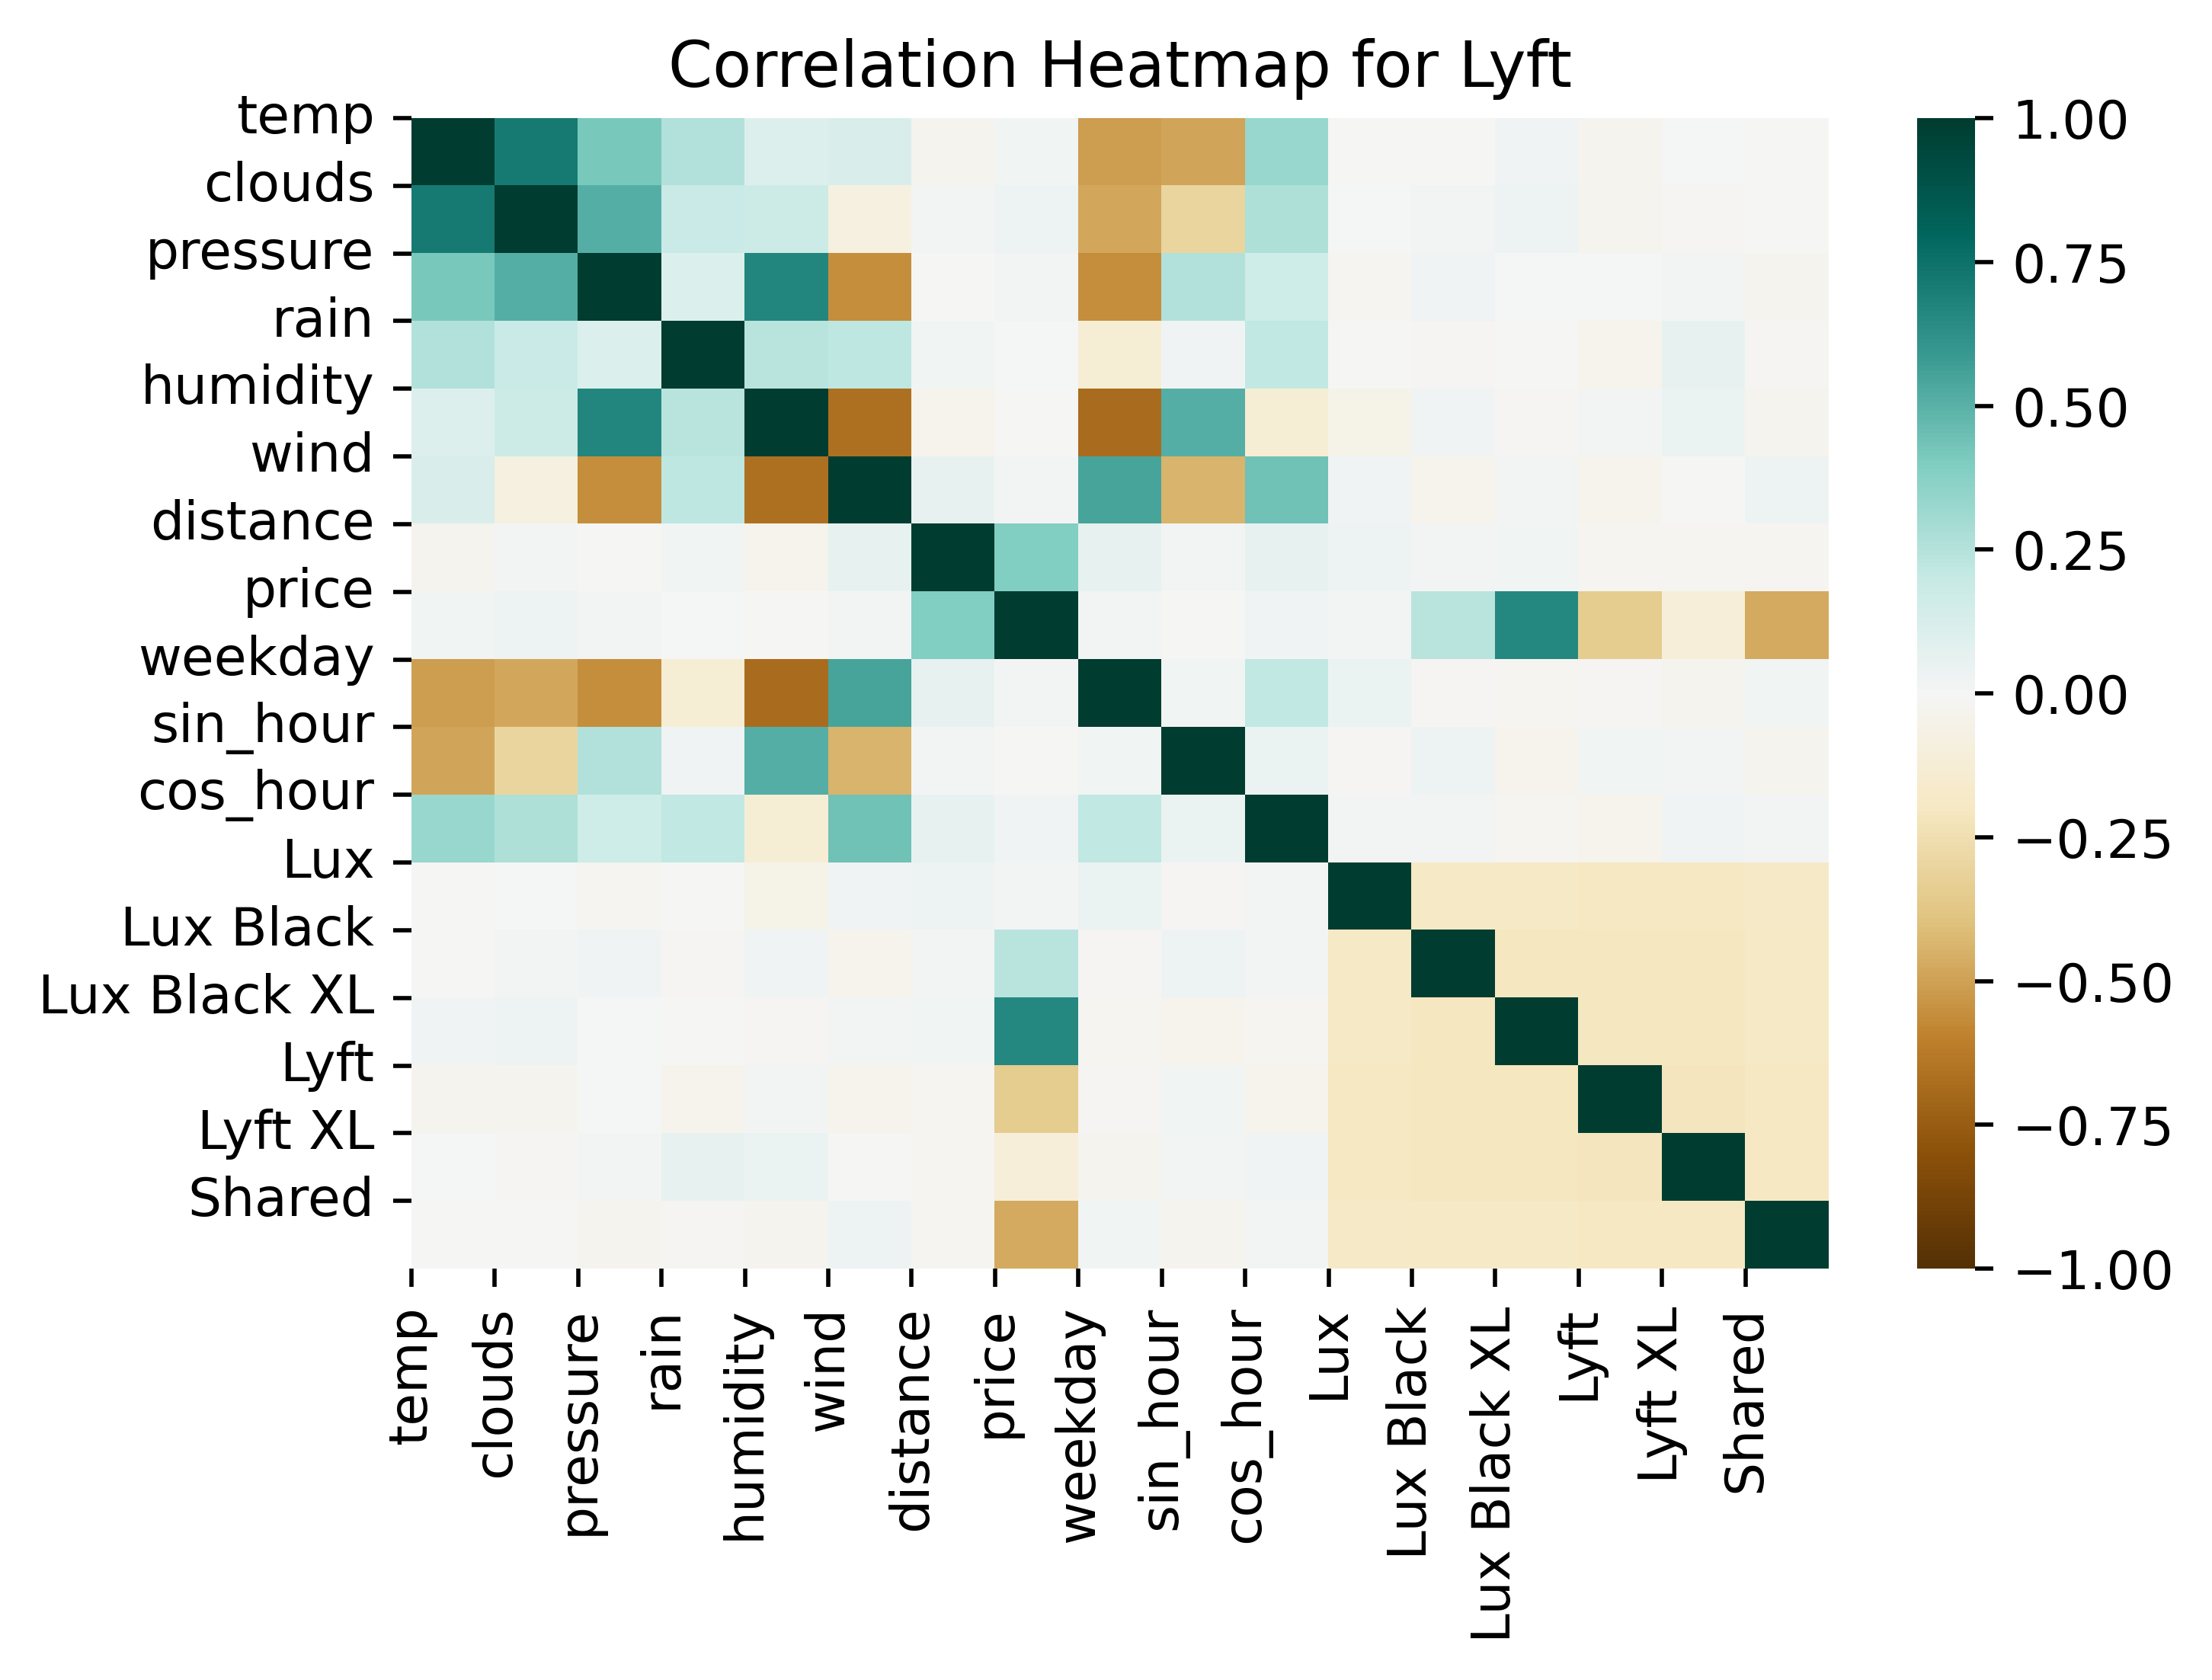

In [ ]:
# create a correlation matrix for Uber and draw heatmap
matrixLyft = dfLyft.corr(method ='pearson')
print(matrixLyft)

ax = sns.heatmap(matrixLyft,vmin=-1, vmax=1, cmap='BrBG')
ax.set_xticks(np.arange(len(matrixLyft)))
ax.set_yticks(np.arange(len(matrixLyft)))
ax.set_xticklabels(matrixLyft.index)
ax.set_yticklabels(matrixLyft.index)
plt.title('Correlation Heatmap for Lyft')
plt.show()

In [ ]:
#drop columns that are correlated with each other
dfLyft = dfLyft.drop(['weekday','rain','price'],1)
print(dfLyft)

In [ ]:
# form traning set and test set for Lyft
featureLyft = dfLyft.columns
print(featureLyft)
dfLyft_np = dfLyft.to_numpy()
np.random.seed(334)
xTrainLyft, xTestLyft, yTrainLyft, yTestLyft = train_test_split(dfLyft_np, dfLyft_price, test_size=0.3)

Index(['temp', 'clouds', 'pressure', 'humidity', 'wind', 'distance',
       'sin_hour', 'cos_hour', 'Lux', 'Lux Black', 'Lux Black XL', 'Lyft',
       'Lyft XL', 'Shared'],
      dtype='object')


Best learning rate for Gradient Boosting for Lyft: 0.1


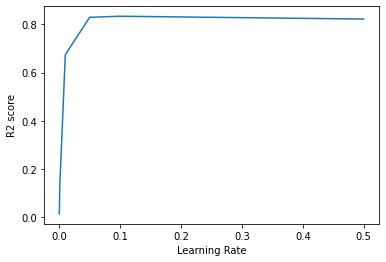

In [ ]:
# Models
# Gradient Boosting - Lyft
# hyper parameter tuning.Selecting best lr
lrs = [0.0001,0.001,0.01,0.05,0.1,0.5]
# empty list that will hold cv scores
cv_scores = []
for k in lrs:
    GB = GradientBoostingRegressor(learning_rate=k)
    scores = cross_val_score(GB, xTrainLyft, yTrainLyft, cv=5, scoring='r2')
    cv_scores.append(scores.mean())
r2 = []
r2 = [x for x in cv_scores]
#optimal K
optimal_k_index = r2.index(max(r2))
optimal_k = lrs[optimal_k_index]
print("Best learning rate for Gradient Boosting for Lyft:", optimal_k)
#plot graph
plt.plot(lrs, r2)
plt.xlabel('Learning Rate')
plt.ylabel('R2 score')
plt.show()

In [ ]:
# find coefficients and R2 score for test set
GB = GradientBoostingRegressor(learning_rate=0.1)
yHatGBLyft = GB.fit(xTrainLyft, yTrainLyft).predict(xTestLyft)
GBmseLyft = metrics.mean_squared_error(yTestLyft, yHatGBLyft)
GBr2Lyft = metrics.r2_score(yTestLyft, yHatGBLyft)
print("Lyft MSE:",GBmseLyft , "; r-squared:", GBr2Lyft)

Lyft MSE: 11.53007252845366 ; r-squared: 0.8813689616778251


Best depth for Decision Tree for Lyft: 5


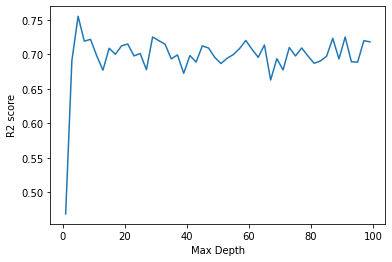

In [ ]:
# Models
# Decision Tree - Lyft
# hyper parameter tuning.Selecting best max depth
depths = [x for x in range(1,100) if x % 2 != 0]
# empty list that will hold cv scores
cv_scores = []
for k in depths:
    DT = DecisionTreeRegressor(max_depth=k)
    scores = cross_val_score(DT, xTrainLyft, yTrainLyft, cv=5, scoring='r2')
    cv_scores.append(scores.mean())
r2 = [x for x in cv_scores]
#optimal K
optimal_k_index = r2.index(max(r2))
optimal_k = depths[optimal_k_index]
print("Best depth for Decision Tree for Lyft:", optimal_k)
#plot graph
plt.plot(depths, r2)
plt.xlabel('Max Depth')
plt.ylabel('R2 score')
plt.show()

In [ ]:
# Decision Tree for Lyft
DT = DecisionTreeRegressor(max_depth=3)
yHatDTLyft = DT.fit(xTrainLyft, yTrainLyft).predict(xTestLyft)

DTmseLyft = metrics.mean_squared_error(yTestLyft, yHatDTLyft)
DTr2Lyft = metrics.r2_score(yTestLyft, yHatDTLyft)
print("Lyft MSE:", DTmseLyft, "; r-squared:", DTr2Lyft)

Lyft MSE: 32.99028457481145 ; r-squared: 0.6605683351951309


Best depth for Random Forest for Lyft: 5


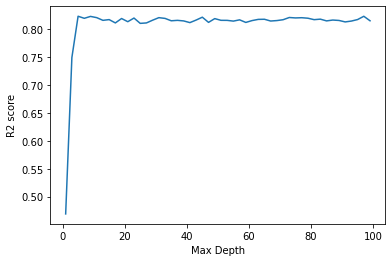

In [ ]:
# Models
# Random Forest - Lyft
# hyper parameter tuning.Selecting best max depth
depths = [x for x in range(1,100) if x % 2 != 0]
# empty list that will hold cv scores
cv_scores = []
for k in depths:
    RF = RandomForestRegressor(max_depth=k)
    scores = cross_val_score(RF, xTrainLyft, yTrainLyft, cv=5, scoring='r2')
    cv_scores.append(scores.mean())
r2 = [x for x in cv_scores]
#optimal K
optimal_k_index = r2.index(max(r2))
optimal_k = depths[optimal_k_index]
print("Best depth for Random Forest for Lyft:", optimal_k)
#plot graph
plt.plot(depths, r2)
plt.xlabel('Max Depth')
plt.ylabel('R2 score')
plt.show()

In [ ]:
# Random Forest for Lyft
RF = RandomForestRegressor(max_depth=5)
yHatRFLyft = RF.fit(xTrainLyft, yTrainLyft).predict(xTestLyft)

RFmseLyft = metrics.mean_squared_error(yTestLyft, yHatRFLyft)
RFr2Lyft = metrics.r2_score(yTestLyft, yHatRFLyft)
print("Lyft MSE:", RFmseLyft, "; r-squared:", RFr2Lyft)


Lyft MSE: 14.889453607803079 ; r-squared: 0.8468048369006727


In [ ]:
uber_list = [0.5,0.2,0.13,0.11,0.06]
lyft_list = [0.6,0.15,0.14,0.13,0.06]
uber_variable_list =["Black SUV", "distance", "rain","temp","clouds"]
lyft_variable_list =["Lux Black XL", "distance", "pressure","temp","clouds"]

In [ ]:
pd_uber_distribution = pd.DataFrame({'variables':uber_variable_list, 'values':uber_list})

In [ ]:
pd_uber_distribution

,variables,values
0,Black SUV,0.50
1,distance,0.20
2,rain,0.13
3,temp,0.11
4,clouds,0.06


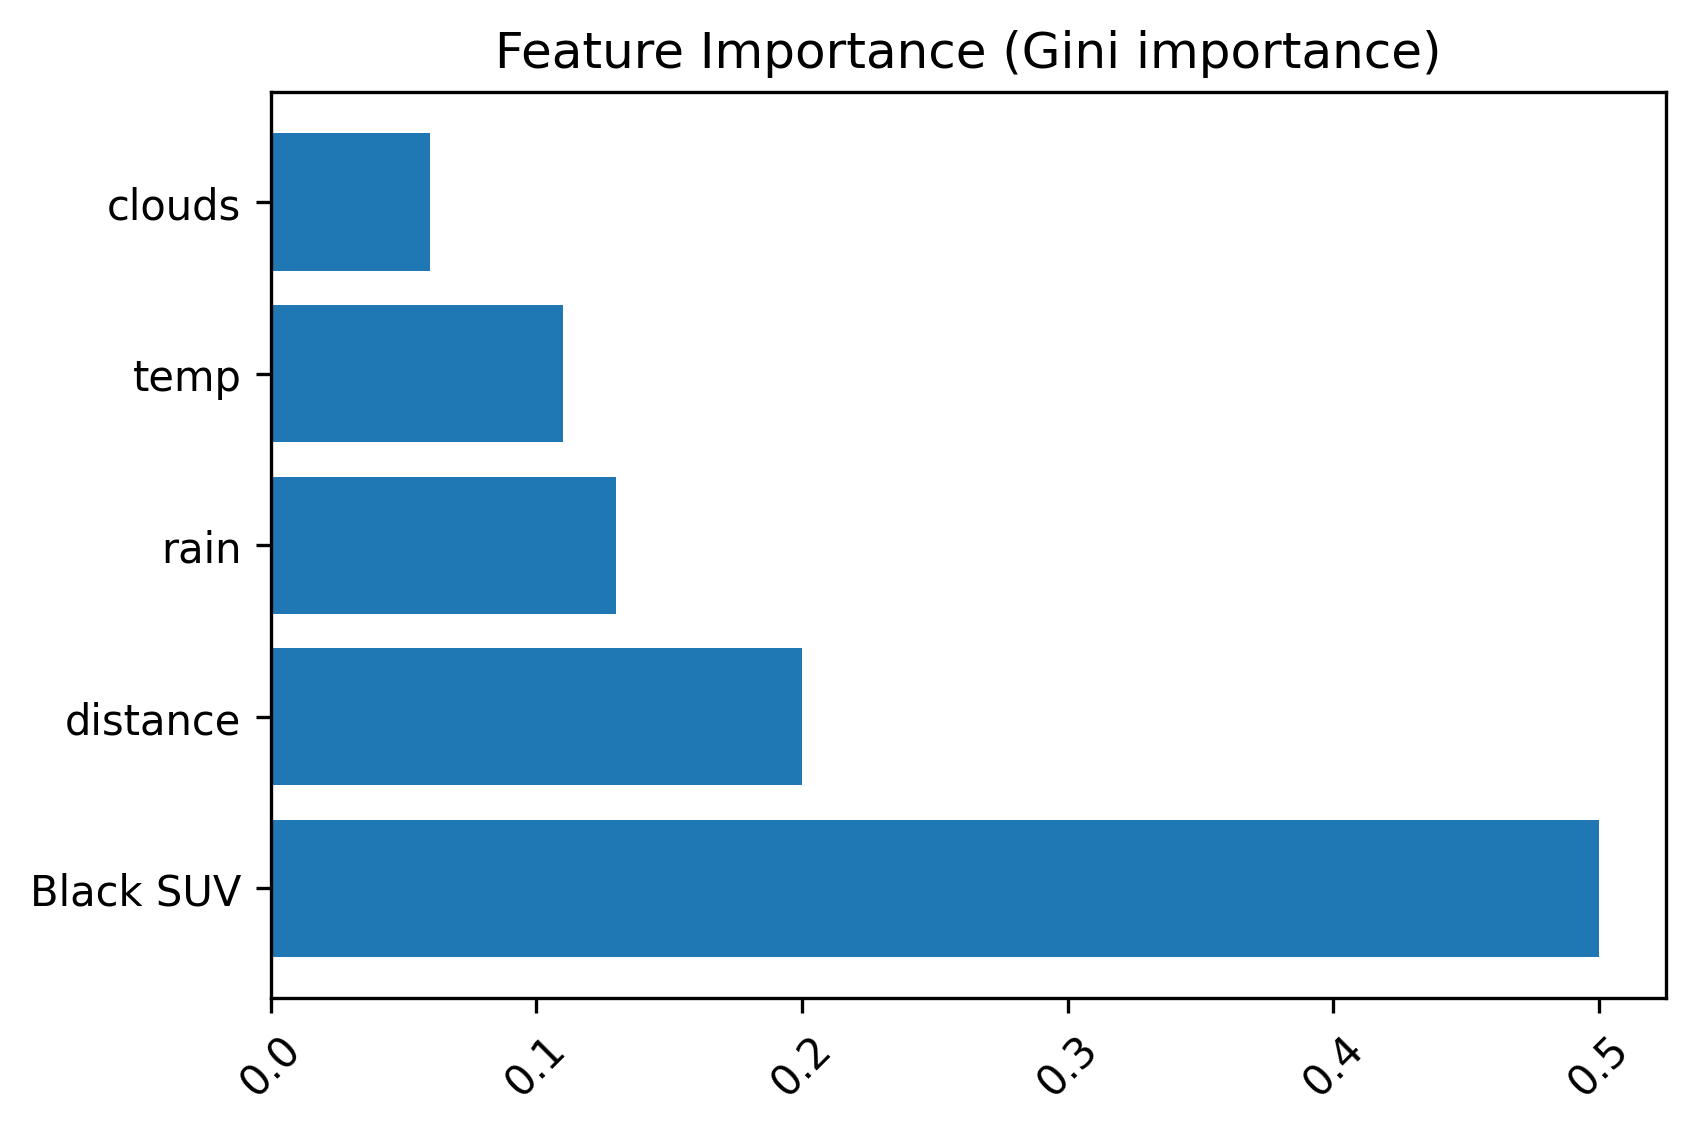

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.barh(uber_variable_list, uber_list)
#plt.xlabel("Company")

plt.title("Feature Importance (Gini importance)")
plt.xticks(rotation=45)
plt.show()

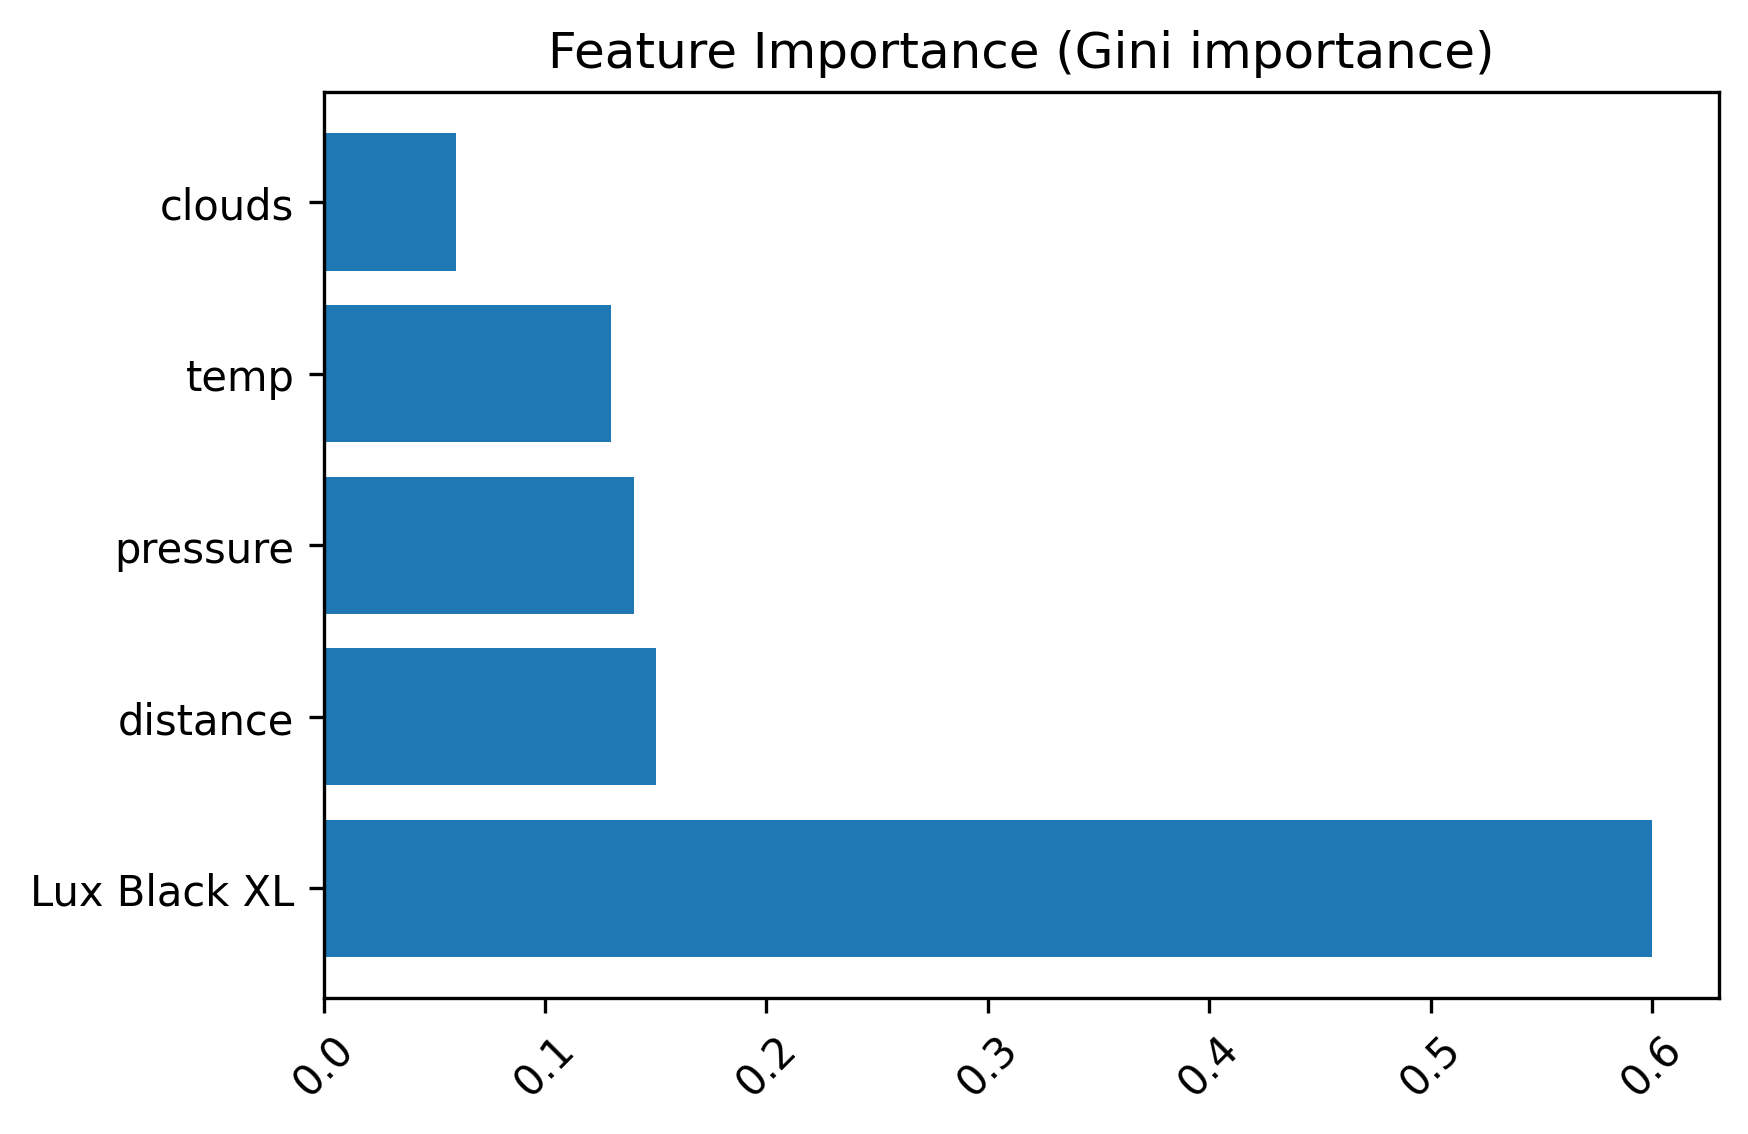

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.barh(lyft_variable_list, lyft_list)
#plt.xlabel("Company")

plt.title("Feature Importance (Gini importance)")
plt.xticks(rotation=45)
plt.show()